# Load the libraries

In [1]:
import os
import csv
import cv2
import numpy as np
import random
import math

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Dropout, Cropping2D
import sklearn
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Prepare the data set 

## Read the data set 

In [2]:
samples = []
with open('./data/data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        samples.append(line)


## Split dataset

In [3]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)


## Define generator 

In [10]:
def generator(samples, batch_size=32, shuffle=True):
    num_samples = len(samples)
    
    while 1: 
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                
                #center_img = cv2.cvtColor(cv2.imread('./data/data/IMG/' + batch_sample[0].split('/')[-1]), cv2.COLOR_BGR2RGB)
                #left_img = cv2.cvtColor(cv2.imread('./data/data/IMG/' + batch_sample[1].split('/')[-1]), cv2.COLOR_BGR2RGB)
                #right_img = cv2.cvtColor(cv2.imread('./data/data/IMG/'+ batch_sample[2].split('/')[-1]), cv2.COLOR_BGR2RGB)

                 for i in [0, 1, 2]:
                    image = cv2.cvtColor(cv2.imread('./data/data/IMG/' + batch_sample[i].split('/')[-1]), cv2.COLOR_BGR2RGB)
                    angle = float(batch_sample[3])
                    correction = 0.4
                    center_angle = angle
                    left_angle = center_angle + correction
                    right_angle = center_angle - correction
                    
                    
                    images.append(image)
                    if(i==0):
                        angles.append(center_angle)
                    elif(i==1):
                        angles.append(left_angle)
                    elif(i==2):
                        angles.append(right_angle)    
                    
                    
                    ### flip
                    images.append(cv2.flip(image,1))
                    if(i==0):
                        angles.append(-1*center_angle)
                    elif(i==1):
                        angles.append(-1*left_angle)
                    elif(i==2):
                        angles.append(-1*right_angle)    
                    

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train) if shuffle else (X_train, y_train)
            
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)            

# Visualize the image from data set

## center, left and right sample image

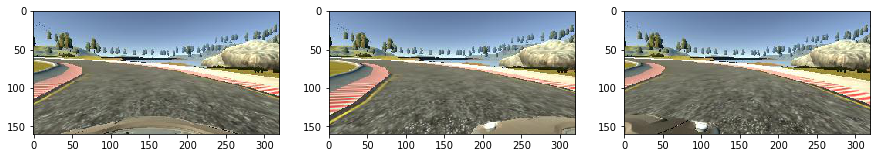

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

img= generator(train_samples, batch_size=32, shuffle=False)
sample_images, _ = next(img)

fig = plt.figure(figsize=(15,5))

for i in [1,2,3]:
    fig.add_subplot(1,3,i)
    sample_image = sample_images[2*(i-1)]
    plt.imshow(sample_image)


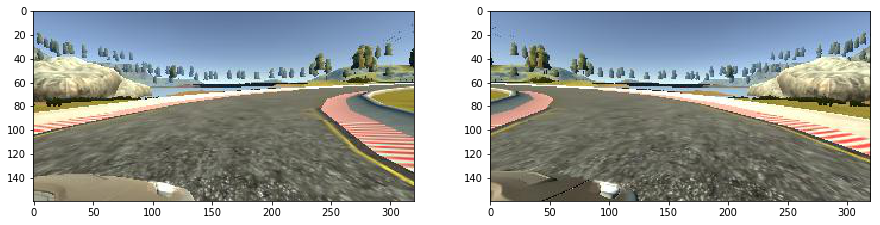

In [20]:
fig = plt.figure(figsize=(15,5))

for image_nb in [1,2]:
    fig.add_subplot(1,2,image_nb)
    sample_image = sample_images[image_nb+2]
    plt.imshow(sample_image)



# the model architecture

In [21]:


#NVIDIA Model
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,20),(0,0))))           
model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 70, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 33, 64)         36928     
__________

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="elu", strides=(2, 2))`
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  # This is added back by InteractiveShel

In [ ]:
model.compile(loss='mse',optimizer='adam')
fit=model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator,   nb_val_samples=len(validation_samples), nb_epoch=5, verbose=1)
model.save('model.h5')

In [ ]:
### plot the mse loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()